In [3]:
import sys
import numpy as np
import holidays
sys.path.append('../')
from model import data_preparation as prep

# Get Some Data

In [4]:
con = prep.create_connection()
x_train_adjusted, y_train_adjusted, x_test_adjusted, y_test_adjusted = prep.prepare_data(con,20)

KeyError: ('is_vacation', 'is_holiday', 'day_of_week')

In [ ]:
x_train_adjusted[0]

# Remove Trend
## with np.log

In [4]:
for key in prepared_data:
    prepared_data[key]["time_series"]["test"] = np.log(prepared_data[key]["time_series"]["test"].reshape(-1,1))
    prepared_data[key]["time_series"]["train"] = np.log(prepared_data[key]["time_series"]["train"].reshape(-1,1))
    

# using partial autocorelation

In [5]:
from statsmodels.tsa.stattools import pacf

keys = list(prepared_data.keys())

x_pacf=pacf( prepared_data[keys[0]]['time_series']['train'] , nlags =10, method='ols')

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
x_pacf # tells us one time lag correlates the most with 0.9

array([ 1.        ,  0.96970856, -0.02422215, -0.01392039, -0.01329386,
       -0.00918525,  0.00126362,  0.02356907,  0.04988052,  0.09641629,
        0.08463859])

# Arrange Data to have List of training instances

In [7]:
 = prep.create_feature_vectors(prepared_data)

In [16]:
x_train_adjusted[0]

array([  9.87099304e-01,   1.42007040e+18,   9.00000000e+00,
         3.06000000e+03,  -8.08779066e+18,   3.10300000e+10,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])

In [8]:
x_train_adjusted = np.array([x_train_adjusted[k] for k in sorted(x_train_adjusted.keys())])
x_train_adjusted = x_train_adjusted.reshape(-1,9)
x_test_adjusted = np.array([x_test_adjusted[k] for k in sorted(x_test_adjusted.keys())])
x_test_adjusted = x_test_adjusted.reshape(-1,9)
y_test_adjusted = np.array([y_test_adjusted[k] for k in sorted(y_test_adjusted.keys())])
y_test_adjusted = y_test_adjusted.reshape(-1,1)
y_train_adjusted = np.array([y_train_adjusted[k] for k in sorted(y_train_adjusted.keys())])
y_train_adjusted = y_train_adjusted.reshape(-1,1)


# normalize price MinMax

In [9]:
maxValue =y_train_adjusted[:,0].max()
x_train_adjusted = x_train_adjusted.astype(float)
x_test_adjusted = x_test_adjusted.astype(float)
x_train_adjusted[:,0] *=1/maxValue
x_test_adjusted[:,0] *=1/maxValue
y_test_adjusted[:,0] *=1/maxValue
y_train_adjusted[:,0] *=1/maxValue

In [10]:
x_train_adjusted[0]

array([  9.87099304e-01,   1.42007040e+18,   9.00000000e+00,
         3.06000000e+03,  -8.08779066e+18,   3.10300000e+10,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])

In [11]:
x_train_adjusted = np.array(x_train_adjusted)
x_test_adjusted = np.array(x_test_adjusted)
#x_train_adjusted = x_train_adjusted.reshape(x_train_adjusted.shape + (1, ))
#x_test_adjusted = x_test_adjusted.reshape(x_test_adjusted.shape + (1, ))

# fitting lasso regression model

seems to fit best our problem with a penalty value of 1e^-6

0.825073420185


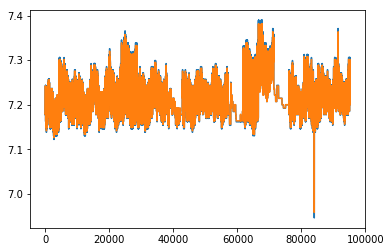

In [12]:
from sklearn import linear_model
import matplotlib.pyplot as plt
clf = linear_model.LassoLars(0.0000001)
clf.fit (x_train_adjusted, y_train_adjusted)
print(clf.score(x_test_adjusted , y_test_adjusted))

plt.plot(np.exp(y_test_adjusted*maxValue))
plt.plot(np.exp(clf.predict(x_test_adjusted)*maxValue))
plt.show()

In [13]:
x_test_adjusted

array([[  9.82993839e-01,   1.48856760e+18,   3.06000000e+03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  9.82993839e-01,   1.48857120e+18,   3.06000000e+03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  9.82993839e-01,   1.48857480e+18,   3.06000000e+03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  9.85592077e-01,   1.50567840e+18,   1.46950000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.84566057e-01,   1.50568200e+18,   1.46950000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.84566057e-01,   1.50568560e+18,   1.46950000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [14]:

from sklearn.metrics import mean_squared_error
mean_squared_error(np.exp(y_test_adjusted*maxValue), np.exp(clf.predict(x_test_adjusted*maxValue)))

0.11009614555954936